<img src="https://s3.amazonaws.com/greenplum.org/wp-content/uploads/2018/11/14180216/logo-gpdb-light.svg" alt="drawing" width="200"/>

# Data Science Workshop

This notebook serves as an hands-on introduction to the data science pipeline.  Using a single dataset throughout, it begins with loading the data into Greenplum Database (GPDB), then proceeds to data exploration, feature engineering, model development, and model evaluation.

We’ll be using the publicly available [Abalone dataset from the University of California, Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/abalone).  The dataset contains nine attributes (including our target prediction column).

| Column Name | Data Type | Description|
| ---|:---:| ---:|
|Sex | text | M,F,I[infant]|
| Length | float | Longest shell measurement|
|Diameter | float | Perpendicular to length|
| Height | float | With meat in shell |
| Whole weight | float | Whole abalone |
| Shucked weight | float | Weight of meat only |
| Viscera weight | float | Gut weight (after bleeding) |
| Shell weight | float | Post-drying |
| Rings | integer | +1.5 gives the age in years|


# Table of contents

<a href="#setup">1. Setup</a>

<a href="#load_data">2. Load data</a>

<a href="#data_review">3. Review raw data</a>

<a href="#explore">4. Explore data</a>

<a href="#classification">5. Classification models</a>

* <a href="#logistic">5a. Logistic regression</a>

* <a href="#forest">5b. Random forest</a>

<a href="#regression">6. Regression models</a>

* <a href="#logistic">6a. Linear regression</a>

* <a href="#elastic">6b. Elastic net</a>

<a id="setup"></a>
# 1. Set Up Your Notebook Environment and Connect to the Database

In [1]:
# this command allows for visualizations to appear in the notebook
%matplotlib inline
%load_ext sql
import math
import six
import pandas as pd
from sqlalchemy import create_engine
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 200)

Connect to Database

In [3]:
# Greenplum Database 5.x on GCP (PM demo machine) - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

<a id="load_data"></a>
# 2. Load Abalone Data

An [abalone](https://simple.wikipedia.org/wiki/Abalone) is a salt water univalve mollusc.
We'll load the data from ```web external table``` then start looking at the data.

In [4]:
%%sql
---
--- The below code will create an external table that points at the data available at IMS/UCI.
---
drop external table if exists abalone_web;
create external web table
        abalone_web (
        sex char(1),
        length float,
        diameter float,
        height float,
        whole_weight float,
        shucked_weight float,
        viscera_weight float,
        shell_weight float,
        rings integer
    )
    location ( 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data' )
    format 'TEXT' ( delimiter ',' null '' )
    log errors
    segment reject limit 100
;
select * from abalone_web limit 10
;

Done.
Done.
10 rows affected.


sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
M,0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7
F,0.53,0.42,0.135,0.677,0.2565,0.1415,0.21,9
M,0.44,0.365,0.125,0.516,0.2155,0.114,0.155,10
I,0.33,0.255,0.08,0.205,0.0895,0.0395,0.055,7
I,0.425,0.3,0.095,0.3515,0.141,0.0775,0.12,8
F,0.53,0.415,0.15,0.7775,0.237,0.1415,0.33,20
F,0.545,0.425,0.125,0.768,0.294,0.1495,0.26,16
M,0.475,0.37,0.125,0.5095,0.2165,0.1125,0.165,9
F,0.55,0.44,0.15,0.8945,0.3145,0.151,0.32,19


Create heap table

In [5]:
%%sql
DROP TABLE IF EXISTS abalone;
CREATE TABLE abalone (
        id integer,
        sex char(1),
        length float,
        diameter float,
        height float,
        whole_weight float,
        shucked_weight float,
        viscera_weight float,
        shell_weight float,
        rings integer
    )
;
    
DROP SEQUENCE IF EXISTS abalone_id ;
CREATE TEMPORARY SEQUENCE abalone_id MINVALUE 0 START 0;

insert into 
     abalone 
select 
      nextval('abalone_id') as id, *
FROM 
      abalone_web
;


SELECT * FROM abalone ORDER BY id LIMIT 10;

Done.
Done.
Done.
Done.
4177 rows affected.
10 rows affected.


id,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
1,M,0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7
2,F,0.53,0.42,0.135,0.677,0.2565,0.1415,0.21,9
3,M,0.44,0.365,0.125,0.516,0.2155,0.114,0.155,10
4,I,0.33,0.255,0.08,0.205,0.0895,0.0395,0.055,7
5,I,0.425,0.3,0.095,0.3515,0.141,0.0775,0.12,8
6,F,0.53,0.415,0.15,0.7775,0.237,0.1415,0.33,20
7,F,0.545,0.425,0.125,0.768,0.294,0.1495,0.26,16
8,M,0.475,0.37,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.55,0.44,0.15,0.8945,0.3145,0.151,0.32,19


<a id="data_review"></a>
# 3. Review raw data

Load some data into a local variable ```abalone```

In [6]:
abalone = %sql select * from abalone where random() < 1.0 order by id limit 5000;
abalone = abalone.DataFrame()

4177 rows affected.


In [7]:
abalone.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
id                4177 non-null int64
sex               4177 non-null object
length            4177 non-null float64
diameter          4177 non-null float64
height            4177 non-null float64
whole_weight      4177 non-null float64
shucked_weight    4177 non-null float64
viscera_weight    4177 non-null float64
shell_weight      4177 non-null float64
rings             4177 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 326.4+ KB


We're interested in estimating the age of the abalone in the data.  To get age, add 1.5 to the number of rings.  A good place to begin is to create a histogram of the target variable.

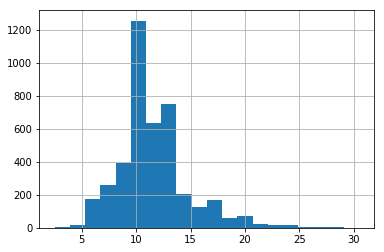

In [8]:
(abalone.rings + 1.5 ).hist(bins=20);

In [9]:
((abalone.rings + 1.5) >= 10).value_counts()

True     2770
False    1407
Name: rings, dtype: int64

### Look at the cumulative distribution

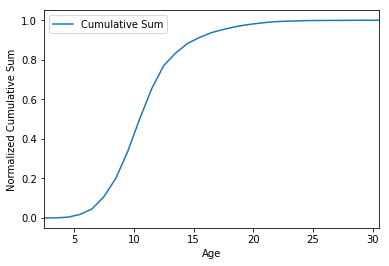

In [10]:
n_cumsum_df = pd.DataFrame({'Cumulative Sum':((abalone.rings + 1.5).value_counts().sort_index().cumsum())/abalone.shape[0]})
ax = n_cumsum_df.plot();
ax.set_xlabel('Age');
ax.set_ylabel('Normalized Cumulative Sum');

<a id="explore"></a>
# 4. Process and explore data

Create a column for maturity

In [11]:
%%sql
DROP TABLE IF EXISTS abalone_target;
CREATE TABLE abalone_target
AS
SELECT 
    id,
    lower(sex) as sex,                     --- ensure that sex is indicated in lower case  (m, f, i)
    "length",
    diameter,
    height,
    whole_weight,
    shucked_weight,
    viscera_weight,
    shell_weight,
    rings,
    rings + 1.5 as age,                    --- Define the age
    CASE WHEN                              --- Identifies whether the abalone is mature or not (1/0)
            (rings + 1.5) >= 10.0
        THEN 1
        ELSE 0
    END as mature
FROM abalone
;
SELECT * FROM abalone_target LIMIT 10;  --- show a sample

Done.
4177 rows affected.
10 rows affected.


id,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age,mature
3,m,0.44,0.365,0.125,0.516,0.2155,0.114,0.155,10,11.5,1
7,f,0.545,0.425,0.125,0.768,0.294,0.1495,0.26,16,17.5,1
11,m,0.43,0.35,0.11,0.406,0.1675,0.081,0.135,10,11.5,1
15,m,0.5,0.4,0.13,0.6645,0.258,0.133,0.24,12,13.5,1
19,m,0.45,0.32,0.1,0.381,0.1705,0.075,0.115,9,10.5,1
23,f,0.55,0.415,0.135,0.7635,0.318,0.21,0.2,9,10.5,1
27,m,0.59,0.445,0.14,0.931,0.356,0.234,0.28,12,13.5,1
31,f,0.68,0.56,0.165,1.639,0.6055,0.2805,0.46,15,16.5,1
35,m,0.465,0.355,0.105,0.4795,0.227,0.124,0.125,8,9.5,0
39,m,0.355,0.29,0.09,0.3275,0.134,0.086,0.09,9,10.5,1


## Encode categorical variables

Next use [MADlib to one-hot encode](http://madlib.apache.org/docs/latest/group__grp__encode__categorical.html) the “sex” column which is a categorical variable.  In order to create a predictive model, we need all our columns to be numerical values.  Making sure all our model inputs conform to this standard is an important part of the data science modeling pipeline and is considered part of the preprocessing/data cleaning step of the process.

In [12]:
%%sql
DROP TABLE IF EXISTS abalone_encoded;
SELECT
madlib.encode_categorical_variables (
        'abalone_target',  -- input table
        'abalone_encoded',  -- output table
        'sex',   -- categorical_cols
        NULL,  --categorical_cols_to_exclude    -- Optional
        NULL,  --row_id,                         -- Optional
        NULL,  --top,                            -- Optional
        NULL,  --value_to_drop,                  -- Optional
        NULL,  --encode_null,                    -- Optional
        NULL,  --output_type,                    -- Optional
        NULL,  --output_dictionary,              -- Optional
        NULL  --distributed_by                  -- Optional
    )
;
SELECT *
FROM abalone_encoded
LIMIT 10

Done.
1 rows affected.
10 rows affected.


id,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age,mature,sex_f,sex_i,sex_m
5,0.425,0.3,0.095,0.3515,0.141,0.0775,0.12,8,9.5,0,0,1,0
13,0.535,0.405,0.145,0.6845,0.2725,0.171,0.205,10,11.5,1,1,0,0
21,0.38,0.275,0.1,0.2255,0.08,0.049,0.085,10,11.5,1,0,1,0
29,0.575,0.425,0.14,0.8635,0.393,0.227,0.2,11,12.5,1,0,0,1
37,0.45,0.355,0.105,0.5225,0.237,0.1165,0.145,8,9.5,0,1,0,0
45,0.39,0.295,0.095,0.203,0.0875,0.045,0.075,7,8.5,0,0,1,0
53,0.47,0.36,0.12,0.4775,0.2105,0.1055,0.15,10,11.5,1,1,0,0
59,0.505,0.4,0.125,0.583,0.246,0.13,0.175,7,8.5,0,1,0,0
67,0.595,0.495,0.185,1.285,0.416,0.224,0.485,13,14.5,1,1,0,0
75,0.6,0.475,0.15,1.0075,0.4425,0.221,0.28,15,16.5,1,1,0,0


##  Statistics

The next step through the modeling process is to explore our data.  We’ll again use some of MADLib’s built in functionality to generate [descriptive statistics](http://madlib.apache.org/docs/latest/group__grp__summary.html) of our data.  This will generate important information about the data including count, number of missing values, the mean, median, maximum, minimum, interquartile range, mode, and variance.

Note that you only want to do this after converting categorical data to numeric data because otherwise the statistics will not be compute correctly.

In [13]:
%%sql
DROP TABLE IF EXISTS abalone_summary ;
SELECT madlib.summary (
    'abalone_encoded',  -- source_table
    'abalone_summary',  -- output_table
    NULL,  -- target_cols
    NULL,  -- grouping_cols
    TRUE,  -- get_distinct
    TRUE,  -- get_quartiles
    NULL,  -- quantile_array
    10,    -- how_many_mfv
    FALSE  -- get_estimate
)
;

SELECT * FROM abalone_summary LIMIT 15
;

Done.
1 rows affected.
14 rows affected.


group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
None,None,id,1,int4,4177,4177,0,None,0.0,None,4176,0,1,2088.0,1454292.16667,"[2051.42791957426, 2124.57208042574]",0.0,4176.0,1044.0,2088.0,3132.0,"[u'4117', u'4114', u'2700', u'3093', u'3595', u'3529', u'3114', u'3451', u'3185', u'3049']","[5L, 5L, 4L, 4L, 4L, 4L, 4L, 4L, 4L, 4L]"
None,None,length,2,float8,4177,134,0,None,0.0,None,4177,0,0,0.523992099593,0.0144223076483,"[0.520350088942874, 0.527634110243145]",0.075,0.815,0.45,0.545,0.615,"[u'0.55', u'0.625', u'0.575', u'0.58', u'0.6', u'0.62', u'0.5', u'0.57', u'0.63', u'0.61']","[94L, 94L, 93L, 92L, 87L, 87L, 81L, 79L, 78L, 75L]"
None,None,diameter,3,float8,4177,111,0,None,0.0,None,4177,0,0,0.407881254489,0.00984855103022,"[0.404871645997763, 0.410890862979976]",0.055,0.65,0.35,0.425,0.48,"[u'0.45', u'0.475', u'0.4', u'0.5', u'0.47', u'0.48', u'0.455', u'0.46', u'0.44', u'0.485']","[139L, 120L, 111L, 110L, 100L, 91L, 90L, 89L, 87L, 83L]"
None,None,height,4,float8,4177,51,0,None,0.0,None,4175,0,2,0.13951639933,0.00174950266443,"[0.138247926591562, 0.140784872067761]",0.0,1.13,0.115,0.14,0.165,"[u'0.15', u'0.14', u'0.155', u'0.175', u'0.16', u'0.125', u'0.165', u'0.135', u'0.145', u'0.13']","[267L, 220L, 217L, 211L, 205L, 202L, 193L, 189L, 182L, 169L]"
None,None,whole_weight,5,float8,4177,2429,0,None,0.0,None,4177,0,0,0.828742159445,0.240481389202,"[0.813870324055101, 0.843613994834058]",0.002,2.8255,0.4415,0.7995,1.153,"[u'1.1345', u'0.196', u'0.2225', u'0.97', u'0.858', u'1.0835', u'0.4775', u'0.872', u'1.1155', u'1.229']","[11L, 8L, 8L, 7L, 7L, 7L, 7L, 7L, 7L, 7L]"
None,None,shucked_weight,6,float8,4177,1515,0,None,0.0,None,4177,0,0,0.359367488628,0.0492675507435,"[0.352636105342962, 0.366098871913441]",0.001,1.488,0.186,0.336,0.502,"[u'0.175', u'0.2505', u'0.2', u'0.302', u'0.2945', u'0.419', u'0.2025', u'0.165', u'0.096', u'0.097']","[11L, 10L, 9L, 9L, 9L, 9L, 9L, 9L, 9L, 9L]"
None,None,viscera_weight,7,float8,4177,880,0,None,0.0,None,4177,0,0,0.180593607853,0.01201528386,"[0.177269379483621, 0.183917836221432]",0.0005,0.76,0.0935,0.171,0.253,"[u'0.1715', u'0.196', u'0.037', u'0.2195', u'0.0575', u'0.061', u'0.096', u'0.1905', u'0.207', u'0.0265']","[15L, 14L, 13L, 13L, 13L, 13L, 12L, 12L, 12L, 12L]"
None,None,shell_weight,8,float8,4177,926,0,None,0.0,None,4177,0,0,0.238830859469,0.0193773832022,"[0.234609314715373, 0.243052404221663]",0.0015,1.005,0.13,0.234,0.329,"[u'0.275', u'0.25', u'0.315', u'0.185', u'0.265', u'0.17', u'0.285', u'0.3', u'0.22', u'0.175']","[43L, 42L, 40L, 40L, 40L, 37L, 37L, 37L, 36L, 36L]"
None,None,rings,9,int4,4177,28,0,None,0.0,None,4177,0,0,9.93368446253,10.3952659473,"[9.83590635305212, 10.0314625720137]",1.0,29.0,8.0,9.0,11.0,"[u'9', u'10', u'8', u'11', u'7', u'12', u'6', u'13', u'14', u'5']","[689L, 634L, 568L, 487L, 391L, 267L, 259L, 203L, 126L, 115L]"
None,None,age,10,numeric,4177,28,0,None,0.0,None,4177,0,0,11.4336844625,10.3952659473,"[11.3359063530521, 11.5314625720137]",2.5,30.5,9.5,10.5,12.5,"[u'10.5', u'11.5', u'9.5', u'12.5', u'8.5', u'13.5', u'7.5', u'14.5', u'15.5', u'6.5']","[689L, 634L, 568L, 487L, 391L, 267L, 259L, 203L, 126L, 115L]"


## Correlation
Another aspect of the data that we might want to know about is the correlation between different columns.  We turn again to MADlib to provide a ready made function: [correlation()](http://madlib.apache.org/docs/latest/group__grp__correlation.html).

In [14]:
%%sql
DROP TABLE IF EXISTS abalone_correlations;
DROP TABLE IF EXISTS abalone_correlations_summary;

SELECT
madlib.correlation(
    'abalone_encoded', -- source_table,
    'abalone_correlations', -- output_table,
    'length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings', -- target_cols,
    TRUE, -- verbose,
    'sex_f,sex_i,sex_m'  -- grouping_columns
);

Done.
Done.
1 rows affected.


correlation
"Summary for 'Correlation' functionOutput table = abalone_correlationsGrouping columns: sex_f,sex_i,sex_mProducing correlation for columns: length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,ringsTotal run time = ('abalone_correlations', 8, 0.2650470733642578)"


In [15]:
Index = %sql SELECT variable FROM abalone_correlations WHERE sex_m = '1' ORDER BY column_position;
Index = Index.DataFrame();

8 rows affected.


In [16]:
columns =  ','.join(','.join('%s' %x for x in y) for y in Index.values)
print(columns)

length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [17]:
correlations_male = %sql select variable,{columns} from abalone_correlations where sex_m = '1' ORDER BY column_position;
correlations_male = correlations_male.DataFrame()

8 rows affected.


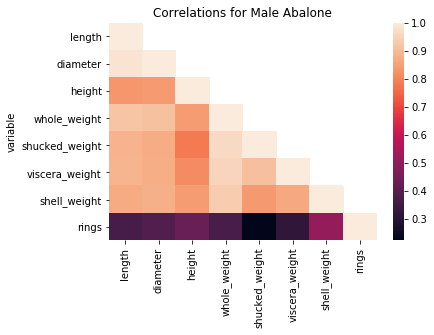

In [18]:
corm = correlations_male.set_index('variable')
ax = sns.heatmap(corm)
ax.set_title('Correlations for Male Abalone')
plt.show();

## Sampling for Training and Testing
Ensuring predictive power in large part is the result of creating a hold-out data set that we don’t train our model with.  By creating this subset of the data, we can test any model we develop against “unseen” data to prevent overfitting by our model.  This has the benefit of generating a predictive model that will generalize better.

There’s no right answer as to how much data to set aside in the test table; a 70&-30% split, weighted towards the training data, is a good rule of thumb.  This process is referred to as the [train-test split](http://madlib.apache.org/docs/latest/group__grp__train__test__split.html).


In [19]:
%%sql
DROP TABLE IF EXISTS abalone_classif CASCADE;
DROP TABLE IF EXISTS abalone_classif_train CASCADE;
DROP TABLE IF EXISTS abalone_classif_test CASCADE;
SELECT madlib.train_test_split(
    'abalone_encoded', -- source_table,
    'abalone_classif', -- output_table,
    0.7, -- train_proportion,
    NULL, -- test_proportion,
    NULL, -- grouping_cols,
    'id,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_f,sex_i,sex_m,rings,age,mature', -- target_cols,
    FALSE, -- with_replacement,
    TRUE -- separate_output_tables
)
;
SELECT count(*) as "Number of abalone in the Training Set" FROM abalone_classif_train
;

Done.
Done.
Done.
1 rows affected.
1 rows affected.


Number of abalone in the Training Set
2924


<a id="classification"></a>
# 5. Classification models

<a id="logistic"></a>
## 5a. Logistic Regression

We’re now ready to create our first predictive model.  We’ll start with a classic [logistic regression](http://madlib.apache.org/docs/latest/group__grp__logreg.html).

Note: we drop one of the 1-hot-encoded variables to remove perfect colinearity

In [20]:
%%sql
DROP TABLE IF EXISTS abalone_logreg_model;
DROP TABLE IF EXISTS abalone_logreg_model_summary;

SELECT
    madlib.logregr_train(                 --- Train the Logistic Regression Model
        'abalone_classif_train', -- source_table,
        'abalone_logreg_model',  -- out_table,
        'mature',                         -- dependent_varname,
        'ARRAY[
            1,
            length,
            diameter,
            height,
            whole_weight,
            shucked_weight,
            viscera_weight,
            shell_weight,
            sex_f,
            sex_m
        ]'                               -- independent_varname,
        --, -- grouping_cols,
        --, -- max_iter,
        --, -- optimizer,
        --, -- tolerance,
        -- verbose
    )
;
SELECT * FROM abalone_logreg_model_summary ;           --- Get the summary table

Done.
Done.
1 rows affected.
1 rows affected.


method,source_table,out_table,dependent_varname,independent_varname,optimizer_params,num_all_groups,num_failed_groups,num_rows_processed,num_missing_rows_skipped,grouping_col
logregr,abalone_classif_train,abalone_logreg_model,mature,"ARRAY[ 1, length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, sex_f, sex_m ]","optimizer=irls, max_iter=20, tolerance=0.0001",1,0,2924,0,None


### Review model weights

In [21]:
%%sql
SELECT * FROM abalone_logreg_model ;

1 rows affected.


coef,log_likelihood,std_err,z_stats,p_values,odds_ratios,condition_no,num_rows_processed,num_missing_rows_skipped,num_iterations,variance_covariance
"[-4.05784038511939, -3.62328869369282, 8.55818901312571, 2.3733575038103, 5.89366234938041, -14.5809268846204, -0.83965986440594, 14.9221884676909, 0.888113766564006, 0.848744890485021]",-1046.57223389,"[0.564717420593037, 3.24087632641859, 3.91946176964484, 2.15175240516033, 1.67142108880738, 1.90735829359554, 2.75043999028889, 2.60184088552192, 0.149323323315725, 0.136327386783195]","[-7.18561219673029, -1.11799659374748, 2.18351128703603, 1.10298819609474, 3.52613855888688, -7.6445662745063, -0.305282015739506, 5.73524251645295, 5.94758907612982, 6.22578419870105]","[6.69067049744631e-13, 0.263568448155912, 0.0289981786733622, 0.27003229123174, 0.000421666297028331, 2.0965080520499e-14, 0.760151371941268, 9.73729156506926e-09, 2.72120689051791e-09, 4.79153223523576e-10]","[0.0172863106068398, 0.0266947411488406, 5209.23876196897, 10.7333691819543, 362.731303482082, 4.65140240376941e-07, 0.431857388520035, 3024294.70742143, 2.4305407575436, 2.33671218095243]",133.151687225,2924,0,7,"[[0.318905765121253, -0.773880756388411, -0.148425130548394, -0.212962995977276, 0.147124898439516, -0.0059678292447954, 0.0793733577772294, 0.290640803033562, -0.00848213277272192, -0.0132695143230618], [-0.773880756388412, 10.5032793631405, -10.8450536351098, -0.065352511565441, -0.379260487944994, 0.115359274386607, -0.695572148171167, 0.0661722900163907, 0.0479683606457261, 0.0518480382948647], [-0.148425130548394, -10.8450536351098, 15.3621805637075, -0.532070275834464, -0.115038424926361, -0.0148346925154307, 0.739742640409678, -1.63384353907477, -0.0363792354548059, -0.030302937293815], [-0.212962995977276, -0.065352511565441, -0.532070275834464, 4.63003841311326, -0.147475204124208, 0.154261272553688, -0.205334564214196, -0.331885157675788, -0.0202805065965652, -0.00482846073312355], [0.147124898439516, -0.379260487944994, -0.115038424926361, -0.147475204124208, 2.79364845611006, -2.78954859556526, -2.71413799091265, -2.70422929299964, -0.0244641928225955, -0.0166449556760013], [-0.00596782924479522, 0.115359274386607, -0.0148346925154308, 0.154261272553688, -2.78954859556526, 3.6380156601477, 1.69176478837567, 2.32499354323252, 0.0299799840419785, 0.00932452525357895], [0.0793733577772295, -0.695572148171167, 0.739742640409678, -0.205334564214196, -2.71413799091265, 1.69176478837567, 7.56492014018035, 1.21738451933247, -0.0376135374474958, -0.0271600174605648], [0.290640803033562, 0.0661722900163907, -1.63384353907477, -0.331885157675788, -2.70422929299964, 2.32499354323252, 1.21738451933247, 6.76957599357349, 0.0255595927423807, 0.0162171662951054], [-0.00848213277272192, 0.0479683606457261, -0.0363792354548059, -0.0202805065965652, -0.0244641928225955, 0.0299799840419784, -0.0376135374474958, 0.0255595927423807, 0.0222974548860525, 0.00974956517302877], [-0.0132695143230618, 0.0518480382948647, -0.030302937293815, -0.00482846073312355, -0.0166449556760013, 0.00932452525357894, -0.0271600174605649, 0.0162171662951054, 0.00974956517302877, 0.0185851563871348]]"


### Show coefficients from model

In [22]:
logreg_coefs = %sql SELECT coef FROM abalone_logreg_model ;
logreg_coefs = logreg_coefs.DataFrame();

1 rows affected.


In [23]:
logreg_coef_names = (
    'intercept',
    'length',
    'diameter',
    'height',
    'whole_weight',
    'shucked_weight',
    'viscera_weight',
    'shell_weight',
    'sex_f',
    'sex_m'
)
tuple(zip(logreg_coef_names, logreg_coefs.iloc[0, 0]))

(('intercept', -4.05784038511939),
 ('length', -3.62328869369282),
 ('diameter', 8.55818901312571),
 ('height', 2.3733575038103),
 ('whole_weight', 5.89366234938041),
 ('shucked_weight', -14.5809268846204),
 ('viscera_weight', -0.83965986440594),
 ('shell_weight', 14.9221884676909),
 ('sex_f', 0.888113766564006),
 ('sex_m', 0.848744890485021))

### Score the model against test data and join with the test data

Now that we have a model with coefficients, we can make predictions on records previously unseen by the model. In the current version of MADlib (1.16), the way to predict probability using a logistic regression model is to `CROSS JOIN` the test set records with the single-row model table. A `CROSS JOIN` produces the cartesian product between all records in both tables, meaning it pairs every record from one table with every record in the other table. In Postgres/Greenplum this can be done be explicitly using the `CROSS JOIN` statement, or you can simply list the two tables in the `FROM` clause separated by a comma. 

In [24]:
%%sql
DROP TABLE IF EXISTS abalone_logreg_test_proba;
CREATE TABLE abalone_logreg_test_proba
AS
SELECT madlib.logregr_predict_prob(   --- Use the logistic regression model to estimate probability of mature
        coef, 
        ARRAY[
            1,
            length,
            diameter,
            height,
            whole_weight,
            shucked_weight,
            viscera_weight,
            shell_weight,
            sex_f,
            sex_m
        ] 
    ) as proba,
    test.mature
FROM abalone_classif_test test, abalone_logreg_model model
;

SELECT *                                   --- take a look at a few of the values
FROM abalone_logreg_test_proba
LIMIT 10
;

Done.
1253 rows affected.
10 rows affected.


proba,mature
0.729460887544,0
0.519030274502,0
0.988936746274,1
0.418889963058,1
0.57689078439,0
0.612402565835,1
0.997554872286,1
0.998395195488,1
0.561654937481,1
0.940089737771,1


### Look at the top model calculated probability vs the actual maturity

In [25]:
%%sql
SELECT proba as probability, mature
    FROM abalone_logreg_test_proba
    ORDER BY probability DESC
    LIMIT 10;

10 rows affected.


probability,mature
0.999999354969,1
0.999987994065,1
0.99998775577,1
0.999981105349,1
0.999967766619,1
0.999963256328,1
0.99994644311,1
0.99994059283,1
0.999937901702,1
0.999913406187,1


### Calculate the area under the ROC

In [26]:
%%sql
drop table if exists abalone_logreg_test_auc;
SELECT
madlib.area_under_roc(
    'abalone_logreg_test_proba', -- table_in, 
    'abalone_logreg_test_auc',  --table_out,
    'proba',  -- prediction_col, 
    'mature'  --observed_col, 
) as result
;
SELECT *
FROM abalone_logreg_test_auc
;

Done.
1 rows affected.
1 rows affected.


area_under_roc
0.91611932129173508483766283524904214559400


### Confusion matrix

In [27]:
%%sql
DROP TABLE IF EXISTS abalone_logreg_test_predict ;
CREATE TABLE abalone_logreg_test_predict
AS
SELECT
    (proba >= 0.5)::integer as predicted,
    mature
FROM abalone_logreg_test_proba
;
SELECT * 
    FROM abalone_logreg_test_predict
    LIMIT 10
;

Done.
1253 rows affected.
10 rows affected.


predicted,mature
1,0
0,1
1,1
1,1
1,1
1,0
1,1
1,1
1,1
1,1


In [28]:
%%sql
DROP TABLE IF EXISTS abalone_logreg_test_conf_matrix;
SELECT
madlib.confusion_matrix(
    'abalone_logreg_test_predict', -- table_in
    'abalone_logreg_test_conf_matrix', -- table_out
    'predicted',  --prediction_col
    'mature' --observation_col
)
;
SELECT                                 --- display the confusion matrix
    row_id,
    class as "Mature",
    confusion_arr[1] as "Predicted: Not Mature",
    confusion_arr[2] as "Mature"
FROM abalone_logreg_test_conf_matrix
ORDER BY row_id
;

Done.
1 rows affected.
2 rows affected.


row_id,Mature,Predicted: Not Mature,Mature_1
1,0,329,112
2,1,75,737


### Get ROC values (thresholds, true-positives, false-positives)

In [29]:
%%sql
DROP TABLE IF EXISTS abalone_logreg_test_binary_metrics ;
SELECT
madlib.binary_classifier(
    'abalone_logreg_test_proba', -- table_in
    'abalone_logreg_test_binary_metrics', -- table_out
    'proba',  --prediction_col
    'mature' --observation_col
)
;
select count(*) from abalone_logreg_test_binary_metrics
;

Done.
1 rows affected.
1 rows affected.


count
1253


In [30]:
%%sql
SELECT *
FROM abalone_logreg_test_binary_metrics
WHERE 
    --round(threshold::numeric, 1) = 0.5
    threshold >= 0.48 AND
    threshold <= 0.52
ORDER BY threshold;

32 rows affected.


threshold,tp,fp,fn,tn,tpr,tnr,ppv,npv,fpr,fdr,fnr,acc,f1
0.480813540438,750,122,62,319,0.923645320197,0.72335600907,0.860091743119,0.837270341207,0.27664399093,0.139908256881,0.076354679803,0.853152434158,0.89073634204275534442
0.480960568056,749,122,63,319,0.922413793103,0.72335600907,0.859931113662,0.835078534031,0.27664399093,0.140068886338,0.0775862068966,0.852354349561,0.89007724301841948901
0.481340339905,749,121,63,320,0.922413793103,0.725623582766,0.86091954023,0.835509138381,0.274376417234,0.13908045977,0.0775862068966,0.853152434158,0.89060642092746730083
0.48298187437,748,121,64,320,0.92118226601,0.725623582766,0.860759493671,0.833333333333,0.274376417234,0.139240506329,0.0788177339901,0.852354349561,0.88994646044021415824
0.484306593506,748,120,64,321,0.92118226601,0.727891156463,0.861751152074,0.833766233766,0.272108843537,0.138248847926,0.0788177339901,0.853152434158,0.89047619047619047619
0.487331142196,747,120,65,321,0.919950738916,0.727891156463,0.861591695502,0.831606217617,0.272108843537,0.138408304498,0.0800492610837,0.852354349561,0.88981536628945801072
0.487774653422,747,119,65,322,0.919950738916,0.730158730159,0.862586605081,0.832041343669,0.269841269841,0.137413394919,0.0800492610837,0.853152434158,0.89034564958283671037
0.488000947327,747,118,65,323,0.919950738916,0.732426303855,0.863583815029,0.832474226804,0.267573696145,0.136416184971,0.0800492610837,0.853950518755,0.89087656529516994633
0.488230774976,746,118,66,323,0.918719211823,0.732426303855,0.863425925926,0.830334190231,0.267573696145,0.136574074074,0.0812807881773,0.853152434158,0.89021479713603818616
0.490427907343,745,118,67,323,0.917487684729,0.732426303855,0.863267670915,0.828205128205,0.267573696145,0.136732329085,0.0825123152709,0.852354349561,0.88955223880597014925


In [31]:
logreg_metrics = %sql SELECT * FROM abalone_logreg_test_binary_metrics ORDER BY threshold;
logreg_metrics = logreg_metrics.DataFrame();

1253 rows affected.


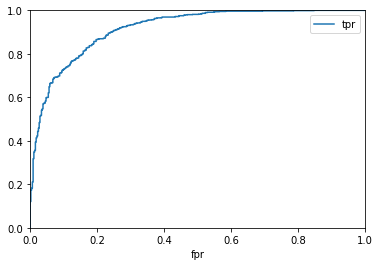

In [32]:
logreg_metrics.plot('fpr', 'tpr',xlim=(0.,1.),ylim=(0.,1.));

<a id="forest"></a>
## 5b. Random Forest 

In [33]:
%%sql
DROP TABLE IF EXISTS abalone_rf_model;
DROP TABLE IF EXISTS abalone_rf_model_group;
DROP TABLE IF EXISTS abalone_rf_model_summary;
SELECT
madlib.forest_train(
    'abalone_classif_train',  -- training_table_name
    'abalone_rf_model',  -- output_table_name
    'id',  -- id_col_name
    'mature',  -- dependent_variable
    'length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_f,sex_m',  -- list_of_features
    NULL,  -- list_of_features_to_exclude
    NULL,  -- grouping_columns
    10  -- number of trees
);

Done.
Done.
Done.
1 rows affected.


forest_train
""


View one of the trees in the forest.  You could also view the tree in dot format, though for random forest tree visualization is less relevant.

In [34]:
%%sql 
SELECT madlib.get_tree('abalone_rf_model', 1, 1, TRUE, TRUE);        

1 rows affected.


get_tree


Get variable importance:

In [35]:
%%sql
DROP TABLE IF EXISTS abalone_rf_importances;
SELECT madlib.get_var_importance(
    'abalone_rf_model',  -- model_table
    'abalone_rf_importances'  -- output_table
)
;
SELECT *
FROM abalone_rf_importances
ORDER BY impurity_var_importance DESC
;

Done.
1 rows affected.
9 rows affected.


feature,oob_var_importance,impurity_var_importance
shell_weight,24.0017517253,17.642923945
shucked_weight,11.2097740558,15.1628653464
whole_weight,8.46230650442,14.5878704374
length,26.5982102015,13.2047421128
viscera_weight,6.12782403239,12.834102126
height,2.41261514408,12.5441452907
diameter,20.1648004008,8.54486297237
sex_f,0.0,3.08539525197
sex_m,1.02271793567,2.39309251727


## Look at some of the predictions

In [36]:
%%sql
DROP TABLE IF EXISTS abalone_rf_test_proba;
SELECT
madlib.forest_predict(
    'abalone_rf_model',  -- random_forest_model
    'abalone_classif_test',  -- new_data_table
    'abalone_rf_test_proba',  -- output_table
    'prob'  -- type
)
;

Done.
1 rows affected.


forest_predict
""


In [37]:
%%sql
SELECT * 
FROM abalone_rf_test_proba
LIMIT 5

5 rows affected.


id,estimated_prob_0,estimated_prob_1
5,1.0,0.0
7,0.0,1.0
13,0.1,0.9
15,0.0,1.0
17,0.6,0.4


In [38]:
%%sql
DROP TABLE IF EXISTS abalone_rf_test_predict_actual;
CREATE TABLE abalone_rf_test_predict_actual
AS
SELECT 
    test.id,
    prob.estimated_prob_1,
    prob.estimated_prob_1 >= 0.5 as predicted_class,
    test.mature as actual_class
FROM 
    abalone_rf_test_proba prob
INNER JOIN
    abalone_classif_test test
ON
    prob.id = test.id

Done.
1253 rows affected.


[]

In [39]:
%%sql
DROP TABLE IF EXISTS abalone_rf_test_binary_metrics;
SELECT
madlib.binary_classifier(
    'abalone_rf_test_predict_actual', -- table_in
    'abalone_rf_test_binary_metrics', -- table_out
    'estimated_prob_1',  --prediction_col
    'actual_class' --observation_col
)
;
SELECT * 
FROM abalone_rf_test_binary_metrics
ORDER BY threshold
LIMIT 15
;

Done.
1 rows affected.
11 rows affected.


threshold,tp,fp,fn,tn,tpr,tnr,ppv,npv,fpr,fdr,fnr,acc,f1
0.0,812,441,0,0,1.0,0.0,0.648044692737,None,1.0,0.351955307263,0.0,0.648044692737,0.78644067796610169492
0.1,807,254,5,187,0.993842364532,0.424036281179,0.760603204524,0.973958333333,0.575963718821,0.239396795476,0.00615763546798,0.793296089385,0.86171916711158569140
0.2,794,221,18,220,0.977832512315,0.498866213152,0.782266009852,0.924369747899,0.501133786848,0.217733990148,0.0221674876847,0.809257781325,0.86918445539135194308
0.3,783,190,29,251,0.964285714286,0.569160997732,0.804727646454,0.896428571429,0.430839002268,0.195272353546,0.0357142857143,0.825219473264,0.87731092436974789916
0.4,774,159,38,282,0.953201970443,0.639455782313,0.829581993569,0.88125,0.360544217687,0.170418006431,0.0467980295567,0.842777334397,0.88710601719197707736
0.5,756,136,56,305,0.931034482759,0.691609977324,0.847533632287,0.84487534626,0.308390022676,0.152466367713,0.0689655172414,0.846767757382,0.88732394366197183099
0.6,744,122,68,319,0.916256157635,0.72335600907,0.859122401848,0.824289405685,0.27664399093,0.140877598152,0.0837438423645,0.848363926576,0.88676996424314660310
0.7,726,110,86,331,0.894088669951,0.750566893424,0.868421052632,0.79376498801,0.249433106576,0.131578947368,0.105911330049,0.843575418994,0.88106796116504854369
0.8,697,91,115,350,0.858374384236,0.793650793651,0.884517766497,0.752688172043,0.206349206349,0.115482233503,0.141625615764,0.835594573025,0.87125000000000000000
0.9,650,62,162,379,0.800492610837,0.859410430839,0.912921348315,0.700554528651,0.140589569161,0.0870786516854,0.199507389163,0.821229050279,0.85301837270341207349


In [40]:
#collect the false positive and true positive rates
rf_metrics = %sql SELECT fpr, tpr FROM abalone_rf_test_binary_metrics ORDER BY threshold;
rf_metrics = rf_metrics.DataFrame();

11 rows affected.


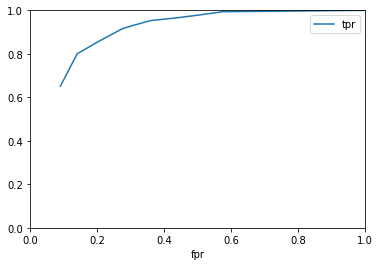

In [41]:
rf_metrics.plot('fpr', 'tpr',xlim=(0.,1.), ylim=(0.,1.))

In [42]:
%%sql
DROP TABLE IF EXISTS abalone_rf_test_auc CASCADE;
SELECT
madlib.area_under_roc(
    'abalone_rf_test_predict_actual', -- table_in
    'abalone_rf_test_auc', -- table_out
    'estimated_prob_1',  --prediction_col
    'actual_class' --observation_col
) as result
;

SELECT * FROM abalone_rf_test_auc ;   -- look at the AUC for the random forest model

Done.
1 rows affected.
1 rows affected.


area_under_roc
0.89330116282966388525837478916032751359985


<a id="regression"></a>
# 6. Regression

Before our target variable was a binary one that we constructed to represent maturity. An abalone was either mature or not mature. Now let's predict its age instead of the binary target. 

<a id="linear"></a>
## 6a. Linear Regression

In [43]:
%%sql
SELECT * 
FROM abalone_classif_train
LIMIT 2

2 rows affected.


id,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_f,sex_i,sex_m,rings,age,mature
1,0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,0,0,1,7,8.5,0
9,0.55,0.44,0.15,0.8945,0.3145,0.151,0.32,1,0,0,19,20.5,1


In [44]:
%%sql
DROP TABLE IF EXISTS abalone_linreg_model;
DROP TABLE IF EXISTS abalone_linreg_model_summary;
SELECT madlib.linregr_train(
    'abalone_classif_train',  -- source_table
    'abalone_linreg_model',  -- out_table
    'age',  -- dependent_varname
    'ARRAY[
        1,
        length,
        diameter,
        height,
        whole_weight,
        shucked_weight,
        viscera_weight,
        shell_weight,
        sex_f,
        sex_m
    ]',  -- independent_varname
    NULL,  -- grouping_cols
    TRUE  -- heteroskedasticity_option
)
;
SELECT * FROM abalone_linreg_model
LIMIT 10
;

Done.
Done.
1 rows affected.
1 rows affected.


coef,r2,std_err,t_stats,p_values,condition_no,bp_stats,bp_p_value,num_rows_processed,num_missing_rows_skipped,variance_covariance
"[4.68130687790161, -1.86032692402494, 13.1337133646984, 9.36556248253984, 9.15490233796625, -19.8355744128492, -9.45078918839029, 7.28175512507301, 0.82552533889907, 0.851845802967165]",0.524226908127,"[0.325501686813575, 2.21450278665342, 2.69481453648041, 1.67685708658124, 0.846912057199183, 0.975099282125397, 1.53333189633054, 1.32122333145544, 0.123253358534541, 0.115179060509793]","[14.3818206404034, -0.840065289254517, 4.87369842595988, 5.58518824143461, 10.809743774628, -20.3421074924947, -6.16356394268405, 5.51137340047691, 6.69779183881402, 7.39583913253694]","[2.31896345659929e-45, 0.400940696068839, 1.15390387709793e-06, 2.54960021405737e-08, 9.88008208055196e-27, 3.97564395495313e-86, 8.09318445456783e-10, 3.87139941463432e-08, 2.52935540568213e-11, 1.82743538026922e-13]",139.647947137,303.441716007,4.8590409809e-60,2924,0,"[[0.105951348118483, -0.292329098226724, 0.0194603449925006, -0.0871355644604966, 0.0146423904770704, 0.0390601332305124, 0.0589660004544375, 0.0656130962684031, 0.00222975556481855, 0.000152924021689542], [-0.292329098226724, 4.90402259209574, -5.36636267929686, -0.0786225408257424, 0.0220697166917959, -0.169874156804451, -0.337971118818921, 0.0657973228862898, 0.0167393243815521, 0.0136965714655914], [0.0194603449925005, -5.36636267929686, 7.2620253860261, -0.437146854612175, -0.053808296838563, 0.0181406050801768, 0.227114374073945, -0.375033629840268, -0.0374784317066128, -0.0274059586165004], [-0.0871355644604966, -0.0786225408257424, -0.437146854612175, 2.81184968881772, -0.0299439811129126, 0.0445862732437427, -0.128425515936003, -0.190501468163422, -0.0149539942784054, -0.0107792271561558], [0.0146423904770705, 0.0220697166917958, -0.0538082968385629, -0.0299439811129126, 0.717260032629352, -0.671693721463654, -0.771338497709632, -0.883172823008288, -0.00421870870335176, -0.00363929394666502], [0.0390601332305124, -0.169874156804451, 0.0181406050801768, 0.0445862732437427, -0.671693721463655, 0.950818610001464, 0.331613424031253, 0.782013976696468, 0.0102411355006135, 0.00420242508277869], [0.0589660004544376, -0.337971118818921, 0.227114374073946, -0.128425515936003, -0.771338497709632, 0.331613424031252, 2.35110670430461, 0.61385954457365, -0.0150418231892282, -0.00922276580850259], [0.0656130962684031, 0.0657973228862898, -0.375033629840268, -0.190501468163422, -0.883172823008288, 0.782013976696468, 0.61385954457365, 1.74563109158222, 0.00308257049568346, 0.00310841801699227], [0.00222975556481855, 0.0167393243815521, -0.0374784317066128, -0.0149539942784054, -0.00421870870335176, 0.0102411355006135, -0.0150418231892282, 0.00308257049568346, 0.0151913903900442, 0.00919494968673803], [0.000152924021689539, 0.0136965714655914, -0.0274059586165004, -0.0107792271561558, -0.00363929394666502, 0.00420242508277869, -0.00922276580850259, 0.00310841801699227, 0.00919494968673804, 0.0132662159799185]]"


### Look at the predictions from the Linear Regression Model

In [45]:
%%sql
DROP TABLE IF EXISTS abalone_linreg_test_predict;
CREATE TABLE abalone_linreg_test_predict
AS
SELECT 
    test.id,
    madlib.linregr_predict(
        coef, 
        ARRAY[
            1,
            length,
            diameter,
            height,
            whole_weight,
            shucked_weight,
            viscera_weight,
            shell_weight,
            sex_f,
            sex_m
        ] 
    ) as predicted_age,
    test.age as actual_age
FROM abalone_classif_test test, abalone_linreg_model model
;
SELECT * FROM abalone_linreg_test_predict
LIMIT 5
;

Done.
1253 rows affected.
5 rows affected.


id,predicted_age,actual_age
1132,12.0617258993,10.5
4053,13.2360737267,11.5
2487,12.8595897242,12.5
2547,7.26327656336,6.5
1723,13.7737768871,13.5


In [46]:
%%sql
drop table if exists abalone_linreg_test_predict_mse;
SELECT madlib.mean_squared_error(
    'abalone_linreg_test_predict',  -- table_in
    'abalone_linreg_test_predict_mse',  -- table_out
    'predicted_age',  -- prediction_col
    'actual_age'  -- observed_col
) as result
;
SELECT * FROM abalone_linreg_test_predict_mse;

Done.
1 rows affected.
1 rows affected.


mean_squared_error
4.58151398735


<a id="elastic"></a>
## 6b. Elastic Net Regression

Elastic Net Regression is linear regression with penalties assigned to the size of the coefficients. Note that   

MADlib's elastic net automatically fits an intercept, so you shouldn't include an explicit intercept column of 1's in your independent variable array.

In [47]:
%%sql
DROP TABLE IF EXISTS abalone_elasticnet_model CASCADE;
DROP TABLE IF EXISTS abalone_elasticnet_model_summary CASCADE;
SELECT madlib.elastic_net_train( 
    'abalone_classif_train',  -- tbl_source
    'abalone_elasticnet_model',  -- tbl_result
    'age',  -- col_dep_var
    'ARRAY[
        length,
        diameter,
        height,
        whole_weight,
        shucked_weight,
        viscera_weight,
        shell_weight,
        sex_f,
        sex_m
    ]',  -- col_ind_var
    'gaussian',  -- regress_family
    0.5,  -- alpha
    0.5,  -- lambda_value
    TRUE  -- standardize
    --,  -- grouping_col
    --,  -- optimizer
    --,  -- optimizer_params
    --,  -- excluded
    --,  -- max_iter
      -- tolerance
)

Done.
Done.
1 rows affected.


elastic_net_train
""


In [48]:
%%sql
SELECT * FROM abalone_elasticnet_model

1 rows affected.


family,features,features_selected,coef_nonzero,coef_all,intercept,log_likelihood,standardize,iteration_run
gaussian,"[u'[1]', u'[2]', u'[3]', u'[4]', u'[5]', u'[6]', u'[7]', u'[8]', u'[9]']","[u'[1]', u'[2]', u'[3]', u'[7]', u'[8]']","[1.21459288235, 3.33557620239, 8.12688807296, 5.89517432659, 0.10448485871]","[1.21459288235, 3.33557620239, 8.12688807296, 0.0, 0.0, 0.0, 5.89517432659, 0.10448485871, 0.0]",6.87900865574,-3.78542947405,True,107


In [49]:
%%sql
SELECT * FROM abalone_elasticnet_model_summary

1 rows affected.


method,source_table,out_table,dependent_varname,independent_varname,family,alpha,lambda_value,grouping_col,num_all_groups,num_failed_groups
elastic_net,abalone_classif_train,abalone_elasticnet_model,age,"ARRAY[ length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, sex_f, sex_m ]",gaussian,0.5,0.5,NULL,1,0


In [50]:
%%sql
DROP TABLE IF EXISTS abalone_elasticnet_test_predict;
CREATE TABLE abalone_elasticnet_test_predict
AS
SELECT 
    test.id,
    madlib.elastic_net_gaussian_predict(
        model.coef_all, 
        model.intercept,
        ARRAY[
            length,
            diameter,
            height,
            whole_weight,
            shucked_weight,
            viscera_weight,
            shell_weight,
            sex_f,
            sex_m
        ] 
    ) as predicted_age,
    test.age as actual_age
FROM abalone_classif_test test, abalone_elasticnet_model model
;

Done.
1253 rows affected.


[]

In [51]:
%%sql
SELECT * FROM abalone_elasticnet_test_predict LIMIT 10

10 rows affected.


id,predicted_age,actual_age
2979,11.3946975401,9.5
1148,11.6158230971,9.5
84,12.3445089064,15.5
1121,11.0038577104,10.5
1129,11.3303543014,9.5
2384,10.3001744313,12.5
1709,13.7373573387,10.5
3061,13.5259365913,11.5
2761,11.5343145387,11.5
1351,12.3149150345,13.5


In [53]:
%%sql
DROP TABLE IF EXISTS abalone_elasticnet_test_predict_mse;
SELECT madlib.mean_squared_error(
    'abalone_elasticnet_test_predict',  -- table_in
    'abalone_elasticnet_test_predict_mse',  -- table_out
    'predicted_age',  -- prediction_col
    'actual_age'  -- observed_col
) 
;
SELECT * FROM abalone_elasticnet_test_predict_mse
;

Done.
1 rows affected.
1 rows affected.


mean_squared_error
6.59702758346
